In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import os
import multiprocessing as mp

from code.models import basicunet, resnetunet
from code.datasets import TGSAugDataset
from code.configs import *
from code.train import *
from code.losses import FocalRobustLoss
from code.metrics import *
from code.augmentations import *
from code.utils import *
from torch.utils.data import DataLoader
from IPython.display import clear_output
from code.inference import *

%matplotlib inline

In [27]:
def train_augment(image, mask):
    if np.random.rand() < 0.5:
        image, mask = do_horizontal_flip2(image, mask)

    if mask.sum() == 0:
        if np.random.rand() < 0.6:
            image, mask = do_elastic_transform2(image, mask, grid=10,
                                                distort=np.random.uniform(0, 0.15))
        if np.random.rand() < 0.6:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.2)
        if np.random.rand() < 0.6:
            image, mask = do_shift_scale_rotate2(image, mask, dx=0, dy=0, scale=1,
                                                 angle=np.random.uniform(0, 10))
        if np.random.rand() < 0.6:
            image, mask = do_horizontal_shear2(image, mask, dx=np.random.uniform(-0.07, 0.07))
    else:
        c = np.random.choice(4)
        if c == 0:
            image, mask = do_elastic_transform2(image, mask, grid=10,
                                                distort=np.random.uniform(0, 0.15))
        elif c == 1:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.2)
        elif c == 2:
            angle = np.random.uniform(0, 15)
            scale = compute_scale_from_angle(angle * np.pi / 180)
            image, mask = do_shift_scale_rotate2(image, mask, dx=0, dy=0, scale=scale,
                                                 angle=angle)
        elif c == 3:
            dx = np.random.uniform(-0.07, 0.07)
            image, mask = do_horizontal_shear2(image, mask, dx=dx)
            image, mask = do_random_crop_from_sheared2(image, mask, dx=dx, limit=0.2)
            
    if np.random.rand() < 0.3:
        c = np.random.choice(3)
        if c == 0:
            image = do_brightness_shift(image, np.random.uniform(-0.1, 0.1))  # 0.05
        elif c == 1:
            image = do_brightness_multiply(image, np.random.uniform(1 - 0.08, 1 + 0.08))  # 0.05
        elif c == 2:
            image = do_gamma(image, np.random.uniform(1 - 0.08, 1 + 0.08))  # 0.05

    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    #image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=32)
    #image, mask = do_resize2(image, mask, 128, 128)
    
    return image, mask

def compute_scale_from_angle(angle):
    return np.sin(angle) + np.cos(angle)

def do_random_perspective2(image, mask, limit):
    borderMode=cv2.BORDER_REFLECT_101
    #cv2.BORDER_REFLECT_101  cv2.BORDER_CONSTANT

    H, W = image.shape[:2]
    H_lim = int(limit * H)
    W_lim = int(limit * W)
    
    dx1 = np.random.randint(1, W_lim)
    dy1 = np.random.randint(1, H_lim)
    
    dx2 = np.random.randint(1, W_lim)
    dy2 = np.random.randint(1, H_lim)
    
    dx3 = np.random.randint(1, W_lim)
    dy3 = np.random.randint(1, H_lim)
    
    dx4 = np.random.randint(1, W_lim)
    dy4 = np.random.randint(1, H_lim)

    box0 = np.array([[0, 0], [W, 0],  [W, H], [0, H]], np.float32)
    #box1 = np.array([[dx, 0], [W + dx, 0], [W - dx, H], [-dx, H]], np.float32)
    box1 = np.array([[-dx1, -dy1], [W + dx2, -dy2], [W + dx3, H + dy3], [-dx4, H + dy4]], 
                    np.float32)

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat = cv2.getPerspectiveTransform(box0, box1)

    image = cv2.warpPerspective(image, mat, (W, H),flags=cv2.INTER_LINEAR,
                                borderMode=borderMode, borderValue=(0, 0, 0))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask  = cv2.warpPerspective(mask, mat, (W, H),flags=cv2.INTER_NEAREST,#cv2.INTER_LINEAR
                                borderMode=borderMode, borderValue=(0, 0, 0))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask  = (mask > 0.5).astype(np.float32)
    
    return image, mask

def do_random_crop_from_sheared2(image, mask, dx, limit=0.10):
    if dx < 0:
        neg = True
        dx = -dx
    else:
        neg = False
    
    if neg:
        image, mask = image[::-1,:], mask[::-1,:]
        
    H, W = image.shape[:2]

    z = int(W * limit)
    x0 = np.random.randint(0, z)
    x1 = W - np.random.randint(0, z)
    
    y0 = max(0, int(H * (1 - x0 / (W * dx)) / 2))
    y1 = min(W, int(H * (1 - x1 / (W * dx) + 1 / dx) / 2))
    
    print(x0, y0, x1, y1)

    image, mask = do_shift_scale_crop(image, mask, x0, y0, x1, y1)
    
    if neg:
        image, mask = image[::-1,:], mask[::-1,:]
    
    return image, mask

def test_augment(image, mask):
    #image, mask = do_resize2(image, mask, 202, 202)
    image, mask = do_center_pad_to_factor2(image, mask, factor=32)
    #image, mask = do_resize2(image, mask, 128, 128)
    return image, mask

In [3]:
train_ds = TGSAugDataset(augmenter=train_augment, path=os.path.join(PATH_TO_SALT_CV, "fold-1/train"), 
                         path_to_depths=PATH_TO_DEPTHS, progress_bar=True)
valid_ds = TGSAugDataset(augmenter=test_augment, path=os.path.join(PATH_TO_SALT_CV, "fold-1/valid"), 
                         path_to_depths=PATH_TO_DEPTHS, progress_bar=True)

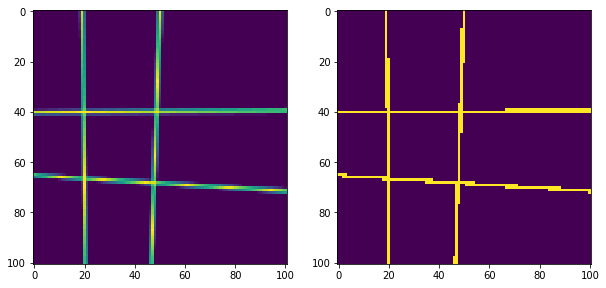

In [69]:
r = train_ds.data[0]

k = np.zeros((101, 101))
k[0,:] = k[-1,:] = k[:,0] = k[:,-1] = 1
k[39,:] = k[-40,:] = k[:,39] = k[:,-40] = 1

image, mask = k, k
image, mask = do_random_perspective2(image, mask, 0.3)

plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [50]:
compute_scale_from_angle(10 * np.pi / 180)

1.1584559306791384

In [70]:
r["mask"]

0.0